In [12]:
import keras
import pandas as pd
import tensorflow as tf

In [13]:
print("Keras version: ", keras.__version__)
print("Tensorflow version: ", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

Keras version:  3.6.0
Tensorflow version:  2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
data_1 = pd.read_csv('mit-bih-data-clear-data.csv')
data_2 = pd.read_csv('ptb-diagnostic-clear-data.csv')
data_3 = pd.read_csv('autonomic-aging-a-dataset-clear-data.csv')


# Feature cleanup
df = pd.concat([data_1, data_2, data_3], ignore_index=True)

df.value_counts('diagnosis')


diagnosis
0.0    1162
1.0     487
Name: count, dtype: int64

In [15]:
# Take 50 samples of each class and remove them from the original dataframe

class_zero = df[df['diagnosis'] == 0].sample(50)
class_one = df[df['diagnosis'] == 1].sample(50)

df = df.drop(class_zero.index)
df = df.drop(class_one.index)

In [16]:
df.value_counts('diagnosis')

diagnosis
0.0    1112
1.0     437
Name: count, dtype: int64

In [17]:
class_zero.to_csv('virgin_class_zero.csv', index=False)
class_one.to_csv('virgin_class_one.csv', index=False)

In [18]:
# Let's check for missing values

df.isnull().sum()


minimum_hrv               0
maximum_hrv               0
standard_deviation_hrv    0
mean_hr_slope             0
tendency_slope            0
lowest_heart_rate         0
vlf_power                 0
lf_power                  0
hf_power                  0
approximation_entropy     0
diagnosis                 0
dtype: int64

In [19]:
import numpy as np
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']
X_resampled, y_resampled = smote.fit_resample(X, y)

df_upsampled = pd.concat([X_resampled, y_resampled], axis=1)




In [20]:
df_upsampled.value_counts('diagnosis')


diagnosis
0.0    1112
1.0    1112
Name: count, dtype: int64

In [21]:
#Uncomment to check Pairplot
# import seaborn as sns
# sns.set_theme(style='ticks')

# sns.pairplot(df_upsampled, hue='diagnosis', kind='kde', corner=True)

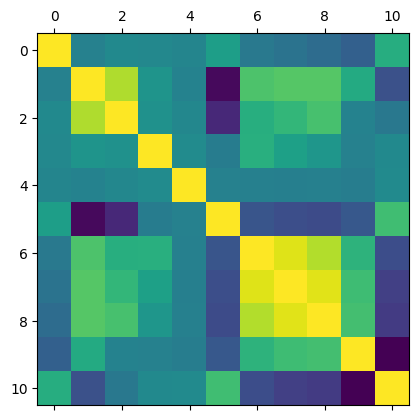

In [22]:
import hr_engine
important_features = [
    'minimum_hrv',
    'maximum_hrv',
    'standard_deviation_hrv',
    'mean_hr_slope',
    'tendency_slope',
    'lowest_heart_rate',
    'vlf_power',
    'lf_power',
    'hf_power',
    'approximation_entropy'
]
from sklearn.impute import SimpleImputer
target = 'diagnosis'

features = df_upsampled[important_features]
# features.replace([np.inf, -np.inf], np.nan, inplace=True)
# imputer = SimpleImputer(strategy='median')

from sklearn.preprocessing import StandardScaler
import joblib

# scaler = StandardScaler()
# features = imputer.fit_transform(features)
# features = scaler.fit_transform(features)
# joblib.dump(scaler, 'scaler.pkl')

features = hr_engine.scale_for_training(features)

df = pd.DataFrame(features, columns=important_features)

df[target] = df_upsampled[target]

df.to_csv('heart_rate_final_data.csv', index=False)

import matplotlib.pyplot as plt
plt.matshow(df.corr())
plt.show()

In [23]:
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']

X.head()

,minimum_hrv,maximum_hrv,standard_deviation_hrv,mean_hr_slope,tendency_slope,lowest_heart_rate,vlf_power,lf_power,hf_power,approximation_entropy
0,3.450431,-0.790035,-0.749342,-0.048090,-0.078912,2.512490,0.545787,0.420836,-0.001643,0.255468
1,1.439435,-0.756102,-0.688494,0.075299,-0.052416,0.576996,2.107190,0.753751,-0.090743,0.308598
2,1.964721,-1.108085,-0.850519,0.025589,-0.044190,1.208488,0.470694,-0.129289,-0.255954,0.134216
3,0.221910,-1.306291,-0.971825,-0.066450,-0.024009,-0.944415,-0.105127,-0.418790,-0.484227,0.845409
4,0.548010,-0.832847,-0.703936,0.018008,0.016628,-0.691628,1.265179,0.628343,-0.053812,0.525548


In [24]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [25]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True)

I0000 00:00:1732785367.512877   59882 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21664 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Training fold 0...


I0000 00:00:1732785369.814050   60373 service.cc:148] XLA service 0x739de0023400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732785369.814270   60373 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-11-28 03:16:09.883023: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732785370.052356   60373 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1732785371.315223   60373 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-11-28 03:16:13.523420: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_81', 220 bytes spill stores, 220 bytes spill loads

2024-11-28 03:16:13.702495: I external/loc

 1/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step

2024-11-28 03:16:54.994773: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33_0', 352 bytes spill stores, 448 bytes spill loads

2024-11-28 03:16:55.008235: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 120 bytes spill stores, 120 bytes spill loads

2024-11-28 03:16:55.286033: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 108 bytes spill stores, 108 bytes spill loads

2024-11-28 03:16:55.347408: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 4 bytes spill stores, 4 bytes spill loads

2024-11-28 03:16:55.427571: I external/local_xla/xla/stream_ex

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step
Fold 0
Confusion Matrix:
 [[140  16]
 [  0 156]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.90      0.95       156
         1.0       0.91      1.00      0.95       156

    accuracy                           0.95       312
   macro avg       0.95      0.95      0.95       312
weighted avg       0.95      0.95      0.95       312



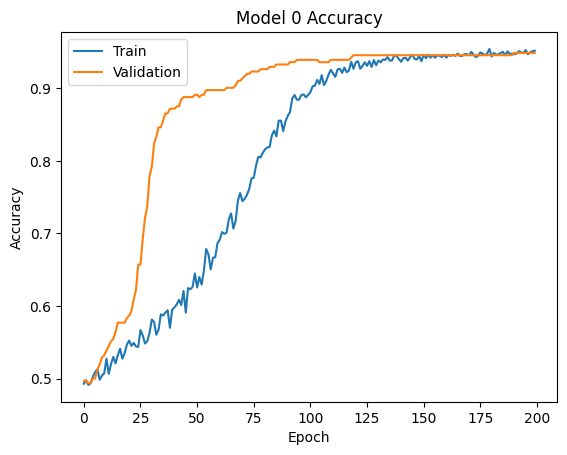

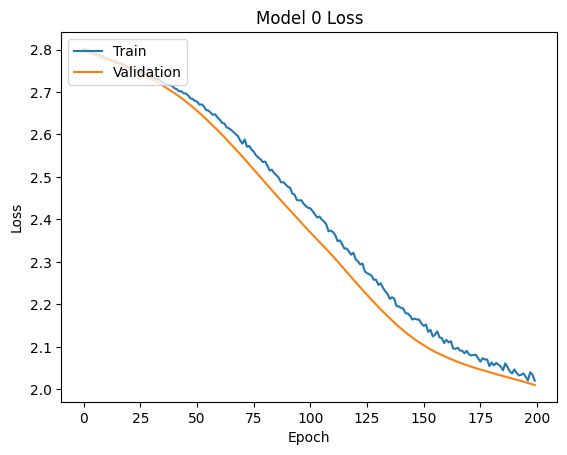

Training fold 1...


2024-11-28 03:16:58.287708: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_77', 220 bytes spill stores, 220 bytes spill loads

2024-11-28 03:16:58.558554: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_77', 4 bytes spill stores, 4 bytes spill loads



 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

2024-11-28 03:17:38.938955: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 104 bytes spill stores, 104 bytes spill loads

2024-11-28 03:17:38.944296: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 4 bytes spill stores, 4 bytes spill loads

2024-11-28 03:17:39.031357: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 92 bytes spill stores, 92 bytes spill loads

2024-11-28 03:17:39.096758: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33_0', 352 bytes spill stores, 448 bytes spill loads

2024-11-28 03:17:39.263800: I external/local_xla/xla/stream_exec

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
Fold 1
Confusion Matrix:
 [[143  12]
 [  1 155]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.92      0.96       155
         1.0       0.93      0.99      0.96       156

    accuracy                           0.96       311
   macro avg       0.96      0.96      0.96       311
weighted avg       0.96      0.96      0.96       311



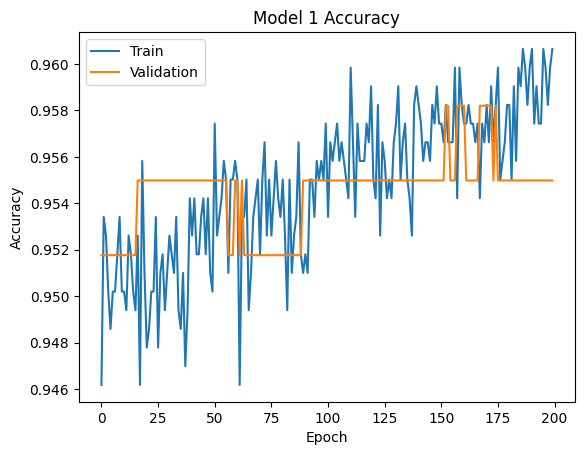

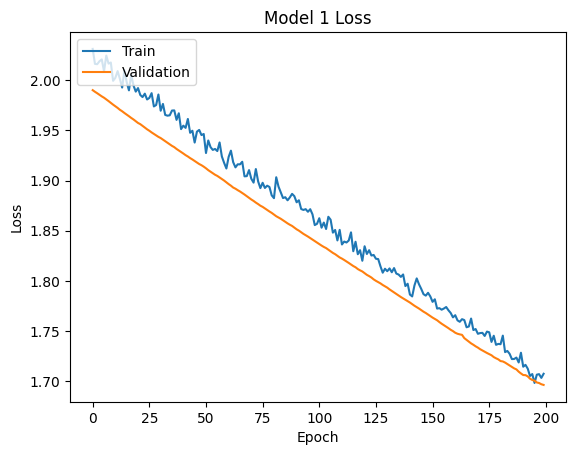

Training fold 2...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step
Fold 2
Confusion Matrix:
 [[146   9]
 [  1 155]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.94      0.97       155
         1.0       0.95      0.99      0.97       156

    accuracy                           0.97       311
   macro avg       0.97      0.97      0.97       311
weighted avg       0.97      0.97      0.97       311



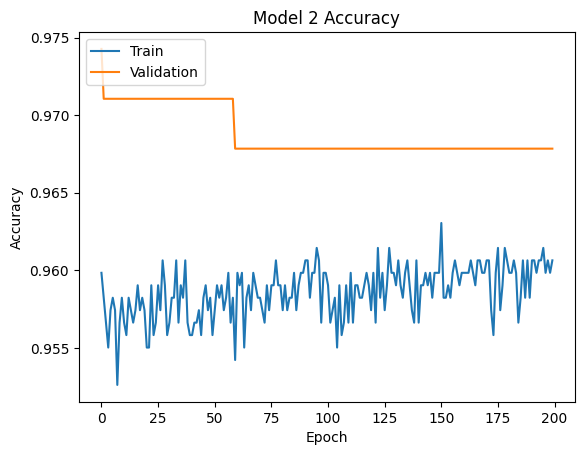

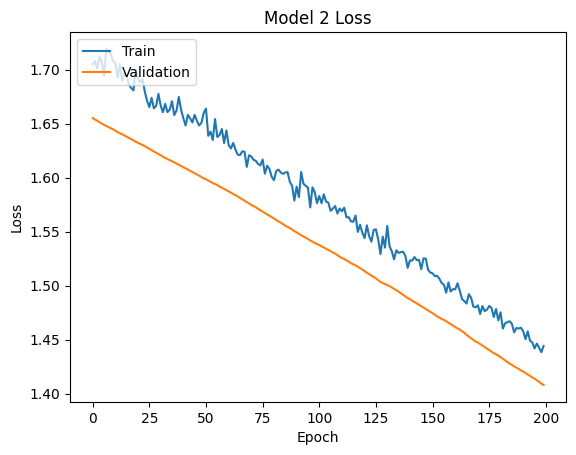

Training fold 3...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
Fold 3
Confusion Matrix:
 [[147   9]
 [  0 155]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.94      0.97       156
         1.0       0.95      1.00      0.97       155

    accuracy                           0.97       311
   macro avg       0.97      0.97      0.97       311
weighted avg       0.97      0.97      0.97       311



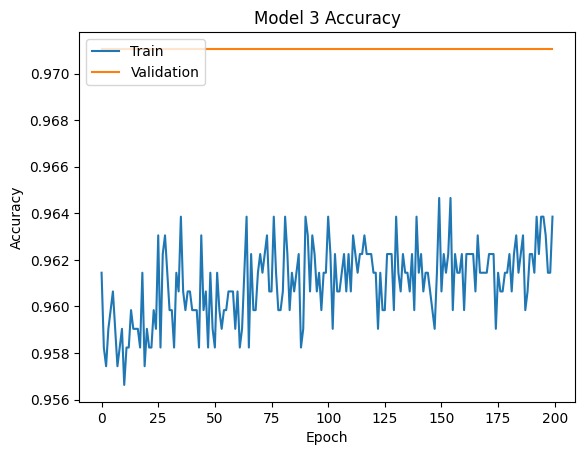

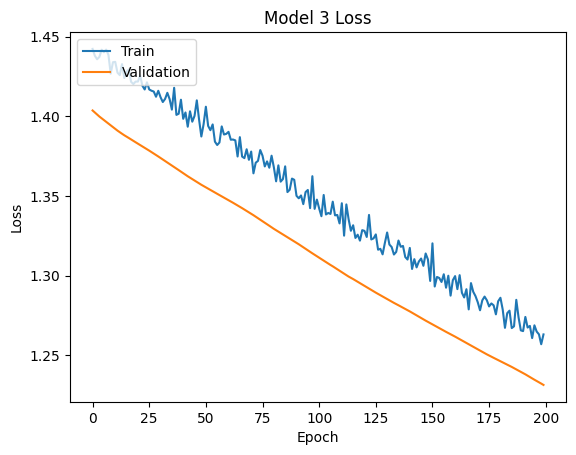

Training fold 4...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
Fold 4
Confusion Matrix:
 [[144  12]
 [  0 155]]

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.92      0.96       156
         1.0       0.93      1.00      0.96       155

    accuracy                           0.96       311
   macro avg       0.96      0.96      0.96       311
weighted avg       0.96      0.96      0.96       311



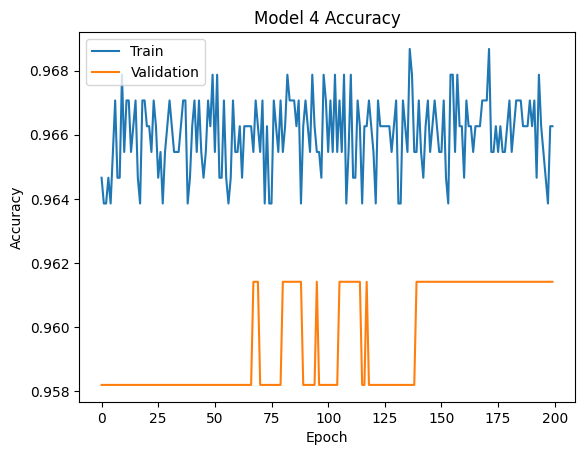

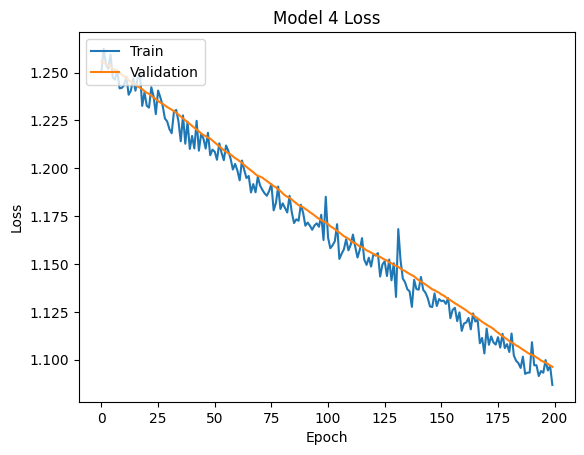

In [26]:
from keras import Sequential, Input
from keras.api.layers import Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.regularizers import l1, l2


accuracy_scores = []
i = 0

def create_model():
    l1_regulizer = l1(0.0001)
    l2_regulizer = l2(0.0001)

    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(2048, activation='relu', kernel_regularizer=l1_regulizer),
        Dropout(0.5),
        Dense(1024, activation='relu', kernel_regularizer=l2_regulizer),
        Dropout(0.4),
        Dense(512, activation='relu', kernel_regularizer=l1_regulizer),
        Dropout(0.4),
        Dense(256, activation='relu', kernel_regularizer=l2_regulizer),
        Dropout(0.4),
        Dense(128, activation='relu', kernel_regularizer=l1_regulizer),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2_regulizer),
        Dropout(0.2),
        Dense(32, activation='relu', kernel_regularizer=l1_regulizer),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.api.optimizers.Adam(learning_rate=0.000001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
initial_weights = model.get_weights()

for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    print(f'Training fold {fold}...')

    if fold > 0:
        model.set_weights(previous_weights)


    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]


    from keras.api.callbacks import ModelCheckpoint, EarlyStopping
    checkpoint = ModelCheckpoint(f'model_{i}.keras', save_best_only=True)
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, epochs=200, batch_size=8, verbose=0, callbacks=[checkpoint, early_stopping], validation_data=(X_test_fold, y_test_fold))
    previous_weights = model.get_weights()

    # Evaluate the model
    y_pred = (model.predict(X_test_fold) > 0.6).astype("int32")
    accuracy = accuracy_score(y_test_fold, y_pred)
    accuracy_scores.append(accuracy)

    cm = confusion_matrix(y_test_fold, y_pred)
    cr = classification_report(y_test_fold, y_pred)
    print(f"Fold {i}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", cr)


    import matplotlib.pyplot as plt

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model {i} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model {i} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
    i += 1

In [27]:
mean_accuracy = np.mean(accuracy_scores)
std_accuracy = np.std(accuracy_scores)

print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")


Mean Accuracy: 0.9614
Standard Deviation of Accuracy: 0.0078
